In [1]:
import scipy.io

import sys
realmin = sys.float_info.min

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
from statistics import NormalDist
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# group = "senate"
# filename = f"/content/drive/My Drive/KPI/KPI навчання/5-6 курс/Дипломне проектування/Article replication/Data/data_{group}.mat"

# dataframe_mat = scipy.io.loadmat(filename)

In [3]:
group = "senate"
dataframe_mat = scipy.io.loadmat(f"Data/data_{group}.mat")

In [4]:
vote_rc = pd.DataFrame(
    data = dataframe_mat['V_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
)
vote_rc = vote_rc.replace({-100: np.nan, -1: 0, 1: 1})

party_leadership_position_rc = pd.DataFrame(
    data = dataframe_mat['party_leadership_position_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc'][0]))] # 1st row as the column names
)
party_leadership_position_rc = party_leadership_position_rc.replace({0: np.nan})

party_list = pd.DataFrame(
    data = dataframe_mat['party_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
)

congress_list = pd.DataFrame(
    data = dataframe_mat['congress_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
)

### 1. Data Preproccessing

In [5]:
print(f"{group.upper()} statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
print(f"\nNumber of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses, id: {np.min(congress_id)} - {np.max(congress_id)})")
print(f"Number of deputies overall = {party_list.size}")

whole_dataset = False
use_matlab_omega_initial_guess = False

if whole_dataset == False:
	congress_id_involved = 71
	print(f"\nCongress id involved: {congress_id_involved}")

	beginning_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id))
	].sum()
	ending_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id) + 1)
	].sum()

	vote_congress = vote_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
	vote_congress_array = np.array(vote_congress)

	party_list_congress = party_list.loc[vote_congress.index]
	party_list_congress_array = np.array(party_list_congress).flatten()

	party_leadership_position_rc_congress = party_leadership_position_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
	party_leadership_position_rc_congress_array = np.array(party_leadership_position_rc_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	print(f"Number of bills in the congress = {T}")
	print(f"Number of deputies in the congress = {N}")
else:
	vote_congress = vote_rc
	vote_congress_array = np.array(vote_congress)

	party_list_congress = party_list
	party_list_congress_array = np.array(party_list_congress).flatten()

	party_leadership_position_rc_congress = party_leadership_position_rc
	party_leadership_position_rc_congress_array = np.array(party_leadership_position_rc_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	print(f"\nNumber of bills = {T}")
	print(f"Number of deputies = {N}")

SENATE statistics
----------------

Number of bills overall = 25824 (46 congresses, id: 70 - 115)
Number of deputies overall = 789

Congress id involved: 71
Number of bills in the congress = 436
Number of deputies in the congress = 108


In [6]:
vote_congress

,192,193,194,195,196,197,198,199,200,201,...,618,619,620,621,622,623,624,625,626,627
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
29,0.0,NaN,1.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
404,0.0,0.0,1.0,NaN,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
407,0.0,NaN,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


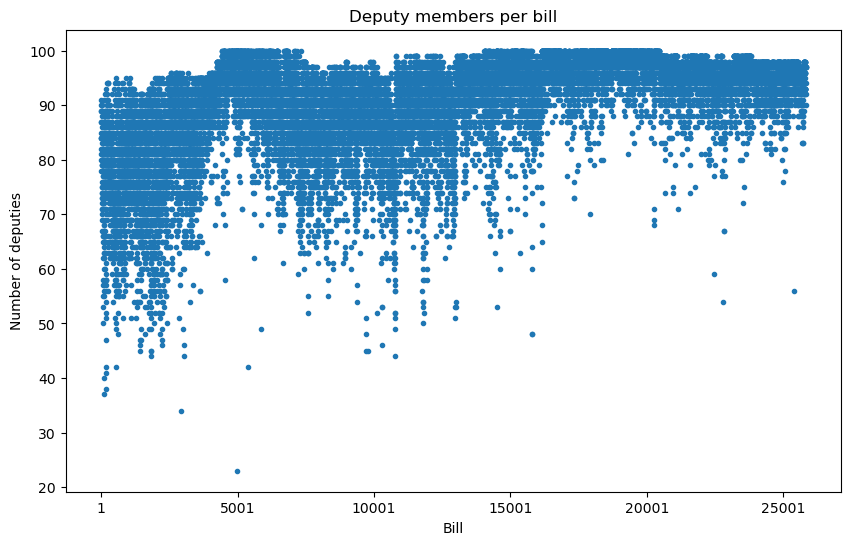

In [7]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

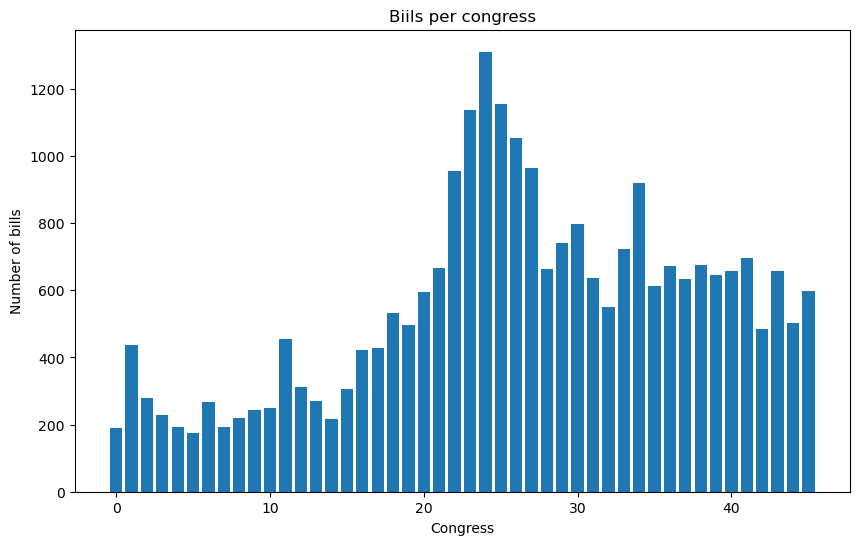

In [8]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

### 2. Initial Guess

In [9]:
random.seed(112)

theta = np.array([random.uniform(0,1) for _ in range(N)])

# Normalize theta
theta = theta - theta[0]

if party_list_congress_array[0] == 100:
	# center Dems around 0 and GOP further right
	theta[1:] = [
		theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5
		for i in range(1,len(theta))
	]
else:
	# center GOP around 0 and Dems further left
	theta[1:] = [
		theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5
		for i in range(1,len(theta))
	]

# initialize ymax
ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

# initialize cutlines for bills
m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

# construct a big parameter vector
omega_initial_guess = np.concatenate([theta, ymax, m])

In [10]:
if use_matlab_omega_initial_guess == True:
    file = open("/content/drive/My Drive/KPI/KPI навчання/5-6 курс/Дипломне проектування/Article replication/Data/omega_0.txt", "r")
    input_omega_initial_guess = np.array(eval(file.readline()))

    ymax = np.array([np.exp(input_omega_initial_guess[0]),np.exp(input_omega_initial_guess[1])])
    theta = input_omega_initial_guess[2:N+2]
    m = input_omega_initial_guess[N+2:N+2+T]

    omega_initial_guess = np.concatenate([theta, ymax, m])

In [11]:
print(f"Parameters of the model: {len(omega_initial_guess)}")

Parameters of the model: 546


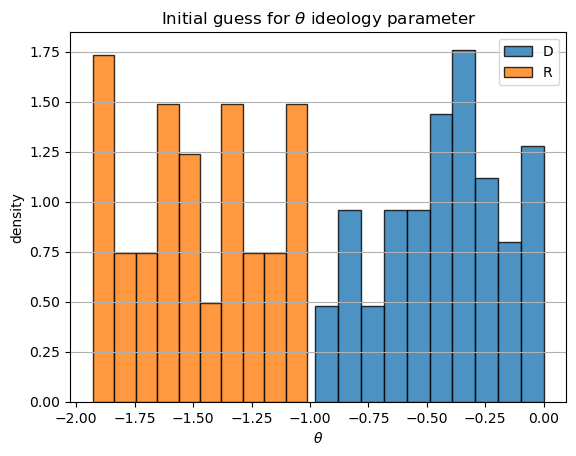

In [12]:
R_omega_initial_guess = [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
D_omega_initial_guess = [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]

plt.hist(D_omega_initial_guess, density=True, label='D', alpha=0.8, edgecolor='black')
plt.hist(R_omega_initial_guess, density=True, label='R', alpha=0.8, edgecolor='black')
plt.legend()

plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Initial guess for $\theta$ ideology parameter")
plt.show()

### 3. Likelihood Optimization

In [13]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [14]:
@njit
def norm_sf(x):
    # (1 - cdf) for the standard normal distribution
    return math.erfc(x / np.sqrt(2.0)) / 2.0

In [15]:
@njit
def neg_likelihood(omega):
	# Unpack (decompose) parameter vector
	theta = np.zeros(N)
	ymax = np.zeros(2)
	m = np.zeros(T)

	for deputy in range(N):
		theta[deputy] = omega[deputy]

	ymax[0], ymax[1] = omega[0 + N], omega[1 + N]

	for bill in range(T):
		m[bill] = omega[N + 2 + bill]


	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		likelihood_pos, likelihood_neg = 0, 0
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)

			if party_leadership_position_rc_congress_array[deputy][bill] == -1.0:
				whip_party_pos = 1.0
				whip_party_neg = -1.0
			if party_leadership_position_rc_congress_array[deputy][bill] == 1.0:
				whip_party_pos = -1.0
				whip_party_neg = 1.0

			cdf_arg_pos = (
				m[bill] - theta[deputy] - whip_party_pos*ymax[party_id]
			)

			cdf_arg_neg = (
				m[bill] - theta[deputy] - whip_party_neg*ymax[party_id]
			)

			# use math.erf() to calculate cdf
			cdf_value_arg_pos = norm_cdf(cdf_arg_pos)
			sf_value_arg_pos = norm_sf(cdf_arg_pos)

			cdf_value_arg_neg = norm_cdf(cdf_arg_neg)
			sf_value_arg_neg = norm_sf(cdf_arg_neg)

			# avoid infinities
			indicator = cdf_value_arg_pos == 0
			cdf_value_arg_pos = indicator*realmin + (1-indicator)*cdf_value_arg_pos
			logcdf_value_arg_pos = np.log(cdf_value_arg_pos)

			indicator = sf_value_arg_pos == 0
			sf_value_arg_pos = indicator*realmin + (1-indicator)*sf_value_arg_pos
			logsf_value_arg_pos = np.log(sf_value_arg_pos)

			indicator = cdf_value_arg_neg == 0
			cdf_value_arg_neg = indicator*realmin + (1-indicator)*cdf_value_arg_neg
			logcdf_value_arg_neg = np.log(cdf_value_arg_neg)

			indicator = sf_value_arg_neg == 0
			sf_value_arg_neg = indicator*realmin + (1-indicator)*sf_value_arg_neg
			logsf_value_arg_neg = np.log(sf_value_arg_neg)

			# use scipy.stats.norm()
			# logcdf_value_arg_pos = scipy.stats.norm.logcdf(cdf_arg_pos)
			# logsf_value_arg_pos = scipy.stats.norm.logsf(cdf_arg_pos)

			# logcdf_value_arg_neg = scipy.stats.norm.logcdf(cdf_arg_neg)
			# logsf_value_arg_neg = scipy.stats.norm.logsf(cdf_arg_neg)

			likelihood_pos += vote_congress_array[deputy][bill] * logcdf_value_arg_pos + \
				(1 - vote_congress_array[deputy][bill]) * logsf_value_arg_pos
			likelihood_neg += vote_congress_array[deputy][bill] * logsf_value_arg_neg + \
				(1 - vote_congress_array[deputy][bill]) * logcdf_value_arg_neg

		likelihood_value += max(likelihood_pos,likelihood_neg)

	return -likelihood_value

In [16]:
start_time = time.time()
print(f"log(L) = {round(neg_likelihood(omega_initial_guess),4)}")
end_time = time.time()
print(f"Time of one execution = {round(end_time-start_time,4)} s")

log(L) = 23937.711
Time of one execution = 1.4625 s


In [17]:
result = minimize(
	fun = neg_likelihood,
	x0 = omega_initial_guess,
	method = "SLSQP", # "SLSQP", "Nelder-Mead", "COBYLA"
    tol = 0.1,
    options = {"disp": True, "maxiter": 100000}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13312.450764829153
            Iterations: 44
            Function evaluations: 24163
            Gradient evaluations: 44


Distance between party centroids = 0.5534


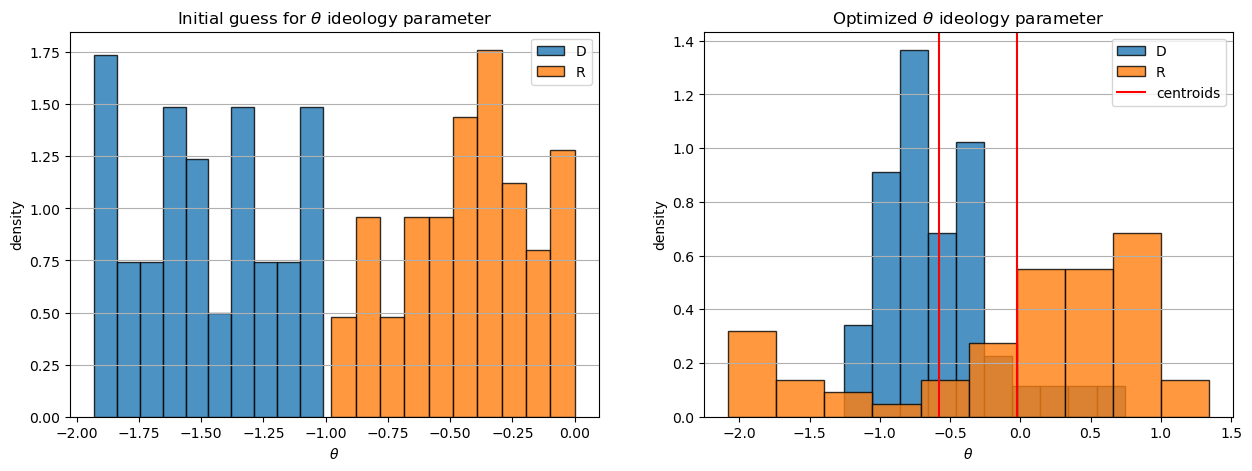

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(
    [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100],
    density=True, label='D', alpha=0.8, edgecolor='black'
)
plt.hist(
    [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200],
    density=True, label='R', alpha=0.8, edgecolor='black'
)
plt.legend()

plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Initial guess for $\theta$ ideology parameter")

omega_hat = result.x
theta_D = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
D_party_centroid = np.mean(theta_D)

theta_R = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
R_party_centroid = np.mean(theta_R)

distance_between_party_centroids = np.abs(R_party_centroid - D_party_centroid)
print(f"Distance between party centroids = {round(distance_between_party_centroids, 4)}")

plt.subplot(1,2,2)
plt.hist(
    [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100],
    density=True, label='D', alpha=0.8, edgecolor='black'
)
plt.hist(
    [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200],
    density=True, label='R', alpha=0.8, edgecolor='black'
)

plt.axvline(R_party_centroid, color="red", label="centroids")
plt.axvline(D_party_centroid, color="red")

plt.legend()
plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Optimized $\theta$ ideology parameter")

plt.show()

### 4. Troubleshooting

In [19]:
notnan_indeces = np.where(~np.isnan(vote_congress_array.T))
notnan_votes = vote_congress_array.T[~np.isnan(vote_congress_array.T)]

In [20]:
notnan_votes

array([0., 0., 0., ..., 0., 1., 1.])

In [21]:
notnan_deputies = notnan_indeces[1]
notnan_deputies

array([  0,   1,   3, ..., 105, 106, 107])

In [22]:
notnan_bills = notnan_indeces[0]
notnan_bills

array([  0,   0,   0, ..., 435, 435, 435])

In [23]:
m[[notnan_bills]] - theta[[notnan_deputies]]

array([[0.74123828, 2.05639735, 2.02304171, ..., 1.06404421, 2.51859571,
        2.35345152]])

In [24]:
cdf_arg = (m[[notnan_bills]] - theta[[notnan_deputies]]).ravel()

In [25]:
p1_python = np.round(np.array([norm_cdf((-1)**(notnan_votes[i])*cdf_arg[i]) for i in range(len(cdf_arg))]),6)
p1_python

array([0.770726, 0.980128, 0.978466, ..., 0.856346, 0.005891, 0.0093  ])

In [ ]:
p1_matlab = np.array([0.645482, 0.580309, 0.750178, 0.350250, 0.289409, 0.467026, 0.774208, 0.822060, 0.673962, 0.214994, 0.168608, 0.313018, 0.796706, 0.745195, 0.871143, 0.178293, 0.226199, 0.110516, 0.254518, 0.312112, 0.167965, 0.775261, 0.822972, 0.675225, 0.210899, 0.263419, 0.134535, 0.437313, 0.505060, 0.322872, 0.179891, 0.138685, 0.730353, 0.526443, 0.593593, 0.406884, 0.649420, 0.710286, 0.532619, 0.421326, 0.748847, 0.354574, 0.293403, 0.471658, ])
p1_matlab

array([0.645482, 0.580309, 0.750178, 0.35025 , 0.289409, 0.467026,
       0.774208, 0.82206 , 0.673962, 0.214994, 0.168608, 0.313018,
       0.796706, 0.745195, 0.871143, 0.178293, 0.226199, 0.110516,
       0.254518, 0.312112, 0.167965, 0.775261, 0.822972, 0.675225,
       0.210899, 0.263419, 0.134535, 0.437313, 0.50506 , 0.322872,
       0.179891, 0.138685, 0.730353, 0.526443, 0.593593, 0.406884,
       0.64942 , 0.710286, 0.532619, 0.421326, 0.748847, 0.354574,
       0.293403, 0.471658])

In [27]:
print(f"p1 python sum = {np.sum(p1_python)}")
print(f"p1 matlab sum = {np.sum(p1_matlab)}")

p1 python sum = 16013.116173000002
p1 matlab sum = 20.617689000000002


In [ ]:
p0_python = np.round(np.array([norm_sf((-1)**(notnan_votes[i])*cdf_arg[i]) for i in range(len(cdf_arg))]),6)
p0_python

array([0.229274, 0.019872, 0.021534, ..., 0.143654, 0.994109, 0.9907  ])

In [ ]:
p0_matlab = np.array([0.354518, 0.419691, 0.249822, 0.649750, 0.710591, 0.532974, 0.225792, 0.177940, 0.326038, 0.785006, 0.831392, 0.686982, 0.203294, 0.254805, 0.128857, 0.821707, 0.773801, 0.889484, 0.745482, 0.687888, 0.832035, 0.224739, 0.177028, 0.324775, 0.789101, 0.736581, 0.865465, 0.562687, 0.494940, 0.677128, 0.820109, 0.861315, 0.269647, 0.473557, 0.406407, 0.593116, 0.350580, 0.289714, 0.467381, 0.578674, 0.251153, 0.645426, 0.706597, 0.528342, ])
p0_matlab

array([0.354518, 0.419691, 0.249822, 0.64975 , 0.710591, 0.532974,
       0.225792, 0.17794 , 0.326038, 0.785006, 0.831392, 0.686982,
       0.203294, 0.254805, 0.128857, 0.821707, 0.773801, 0.889484,
       0.745482, 0.687888, 0.832035, 0.224739, 0.177028, 0.324775,
       0.789101, 0.736581, 0.865465, 0.562687, 0.49494 , 0.677128,
       0.820109, 0.861315, 0.269647, 0.473557, 0.406407, 0.593116,
       0.35058 , 0.289714, 0.467381, 0.578674, 0.251153, 0.645426,
       0.706597, 0.528342])

In [30]:
print(f"p0 python sum = {np.sum(p0_python)}")
print(f"p0 matlab sum = {np.sum(p0_matlab)}")

p0 python sum = 16955.883826999998
p0 matlab sum = 23.382310999999998


In [31]:
data = [1,2,3,4,5,6]
ind = [1,3,4,2,4,1]

import numpy_indexed as npi
arr = npi.group_by(ind).split(data)

In [32]:
np.array([[sum(subgroup)] for subgroup in arr]).ravel()

array([7, 4, 2, 8])

In [33]:
likelihood_pos = npi.group_by(notnan_bills).split(
    notnan_votes*np.log([norm_cdf(arg) for arg in cdf_arg]) + (1-notnan_votes)*np.log([norm_sf(arg) for arg in cdf_arg])
)
likelihood_pos = np.array([[sum(subgroup)] for subgroup in likelihood_pos]).ravel()

likelihood_neg = npi.group_by(notnan_bills).split(
    notnan_votes*np.log([norm_sf(arg) for arg in cdf_arg]) + (1-notnan_votes)*np.log([norm_cdf(arg) for arg in cdf_arg])
)
likelihood_neg = np.array([[sum(subgroup)] for subgroup in likelihood_neg]).ravel()

In [34]:
likelihood_pos = np.log([norm_cdf((-1)**(notnan_votes[i])*cdf_arg[i]) for i in range(len(cdf_arg))])
likelihood_neg = np.log([norm_sf((-1)**(notnan_votes[i])*cdf_arg[i]) for i in range(len(cdf_arg))])

In [35]:
-np.sum(np.max([likelihood_pos,likelihood_neg], axis=0))

8713.039461758226